In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')

# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

#### Dataset 불러오기

In [2]:
kospi_all = pd.read_csv('./dataset/data_kospi_all.csv')
kospi_bad = pd.read_csv('./dataset/data_kospi_bad.csv')
kospi_good = pd.read_csv('./dataset/data_kospi_good.csv')
kosdaq_all = pd.read_csv('./dataset/data_kosdaq_all.csv')
kosdaq_bad = pd.read_csv('./dataset/data_kosdaq_bad.csv')
kosdaq_good = pd.read_csv('./dataset/data_kosdaq_good.csv')

#### 함수

##### train, test 분리 + 데이터 불균형 처리 + 스케일링

In [3]:
def data(df):
    features = df.drop(['target'], axis=1)
    target = df[['target']]

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [4]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [5]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### Logistic Regression

In [6]:
def LG(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

##### Decision Tree

In [7]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [8]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='bankruptcy.dot', class_names=["0", "1"], feature_names= df.drop(['target'], axis=1).columns, impurity=True, filled=True)

    with open('bankruptcy.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

##### SVM

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

##### XGBoost

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

____

#### 코스피

##### All

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.6103525827603561

예측 데이터 정확도
accuracy score : 0.630
precision score : 0.096
recall score : 0.491
f1 score : 0.161
roc score : 0.566
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.10485    0.07337 0.98182   0.13654    0.50927
0.30000   0.19528    0.07970 0.96364   0.14722    0.54961
0.40000   0.39843    0.07741 0.67273   0.13884    0.52492
0.50000   0.63041    0.09609 0.49091   0.16071    0.56608
0.60000   0.80603    0.08108 0.16364   0.10843    0.50978
0.70000   0.89122    0.08824 0.05455   0.06742    0.50538
0.80000   0.91874    0.18182 0.03636   0.06061    0.51183
0.90000   0.92792    0.00000 0.00000   0.00000    0.50000
None


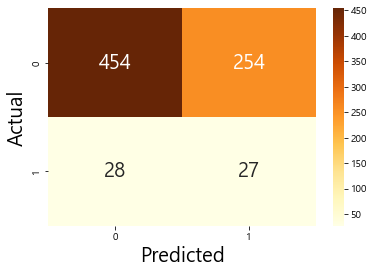

In [11]:
LG(kospi_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.7134099475333138

예측 데이터 정확도
accuracy score : 0.273
precision score : 0.073
recall score : 0.782
f1 score : 0.134
roc score : 0.507
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.23591    0.07282 0.81818   0.13373    0.50443
0.30000   0.26737    0.07432 0.80000   0.13601    0.51299
0.40000   0.26737    0.07432 0.80000   0.13601    0.51299
0.50000   0.27261    0.07338 0.78182   0.13417    0.50743
0.60000   0.89515    0.12121 0.07273   0.09091    0.51588
0.70000   0.89515    0.12121 0.07273   0.09091    0.51588
0.80000   0.89515    0.12121 0.07273   0.09091    0.51588
0.90000   0.92136    0.14286 0.01818   0.03226    0.50485
None


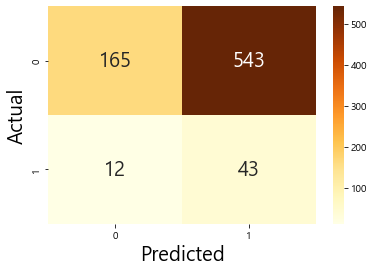

In [12]:
p_all = DT(kospi_all)

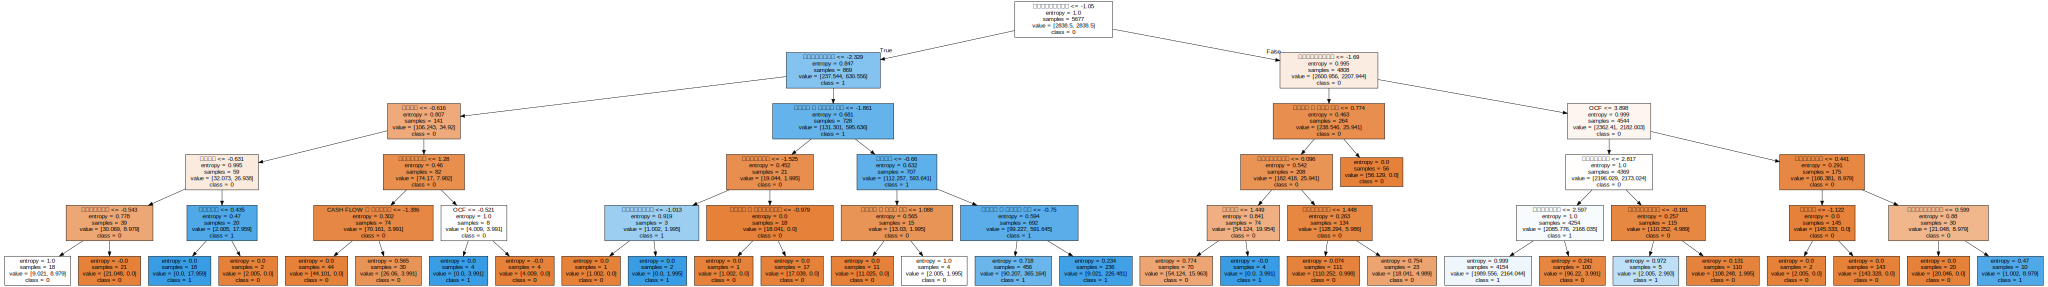

In [13]:
DT_vis(kospi_all, p_all)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8514587631720312

예측 데이터 정확도
accuracy score : 0.878
precision score : 0.048
recall score : 0.036
f1 score : 0.041
roc score : 0.490


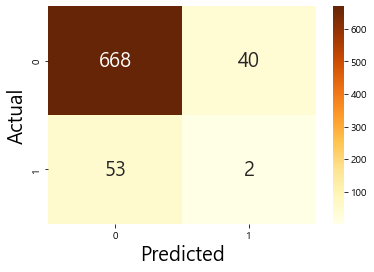

In [14]:
SVM(kospi_all, 'rbf')

In [15]:
# SVM(kospi_all, 'linear')

XGBoost

[00:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 12.967032967032967, 'silent': 1}
학습 데이터 정확도 :  0.9195179519569967

예측 데이터 정확도
accuracy score : 0.785
precision score : 0.071
recall score : 0.164
f1 score : 0.099
roc score : 0.498
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.68545    0.07763 0.30909   0.12409    0.51189
0.30000   0.73132    0.08333 0.27273 

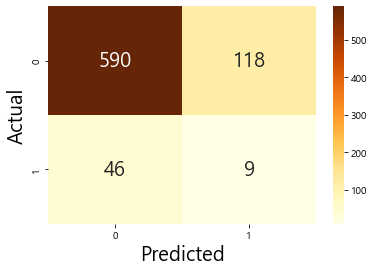

In [16]:
XGB(kospi_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5828796740754851

예측 데이터 정확도
accuracy score : 0.617
precision score : 0.075
recall score : 0.556
f1 score : 0.132
roc score : 0.588
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.08151    0.05263 0.97222   0.09986    0.50224
0.30000   0.20087    0.05391 0.86111   0.10147    0.51274
0.40000   0.32314    0.06135 0.83333   0.11429    0.56413
0.50000   0.61718    0.07491 0.55556   0.13201    0.58807
0.60000   0.82824    0.04444 0.11111   0.06349    0.48950
0.70000   0.90684    0.06250 0.05556   0.05882    0.50474
0.80000   0.93450    0.15385 0.05556   0.08163    0.51933
0.90000   0.94614    0.33333 0.02778   0.05128    0.51235
None


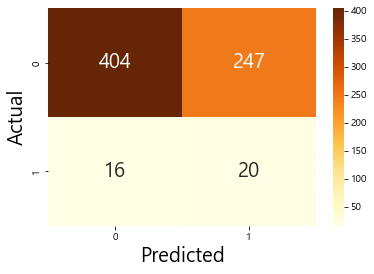

In [17]:
LG(kospi_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6807143442194408

예측 데이터 정확도
accuracy score : 0.636
precision score : 0.058
recall score : 0.389
f1 score : 0.101
roc score : 0.519
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.30131    0.05600 0.77778   0.10448    0.52637
0.30000   0.34498    0.05579 0.72222   0.10359    0.52317
0.40000   0.34643    0.05591 0.72222   0.10379    0.52394
0.50000   0.63610    0.05785 0.38889   0.10072    0.51933
0.60000   0.89229    0.06818 0.08333   0.07500    0.51018
0.70000   0.89229    0.06818 0.08333   0.07500    0.51018
0.80000   0.89229    0.06818 0.08333   0.07500    0.51018
0.90000   0.94469    0.00000 0.00000   0.00000    0.49846
None


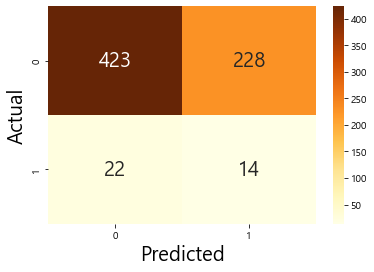

In [18]:
p_bad = DT(kospi_bad)

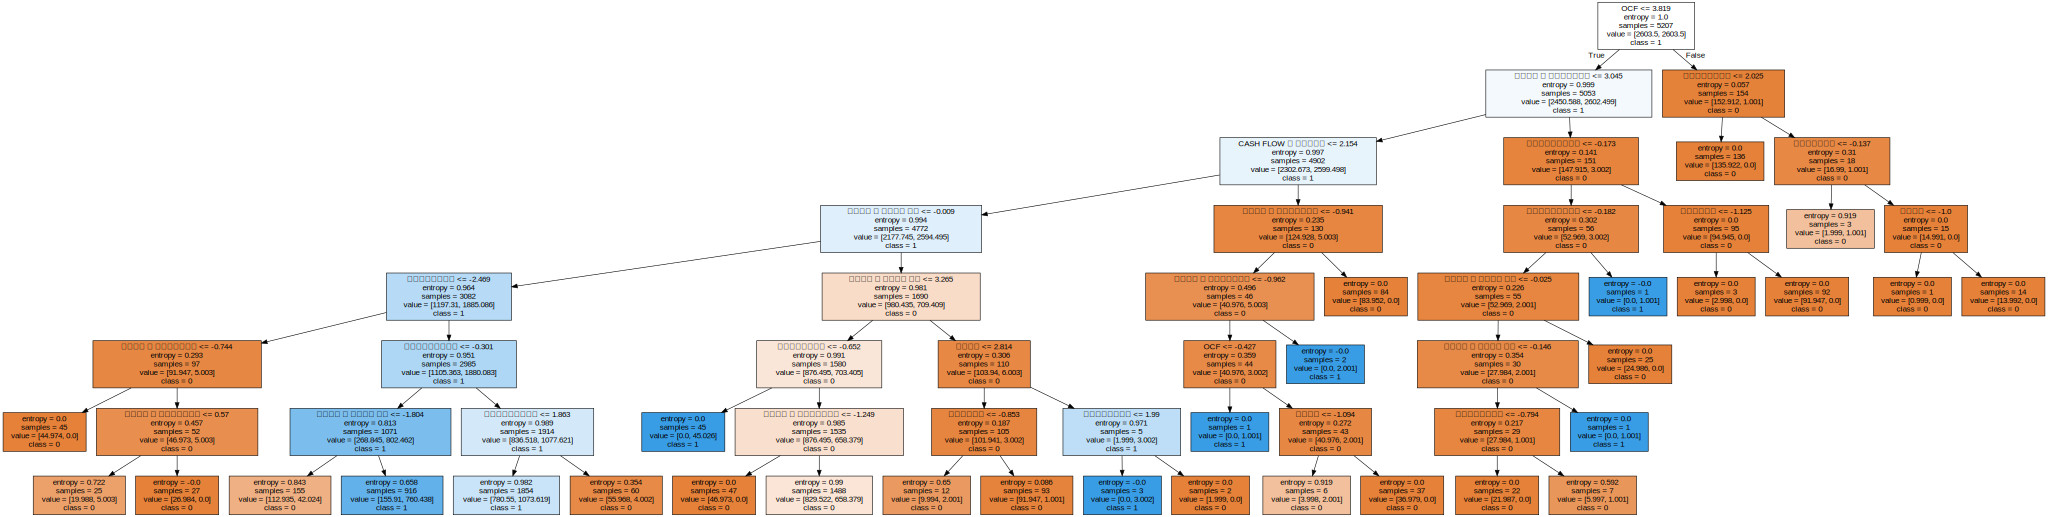

In [19]:
DT_vis(kospi_bad, p_bad)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8450197782813742

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.075
recall score : 0.194
f1 score : 0.109
roc score : 0.531


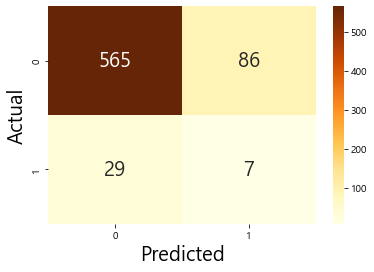

In [20]:
SVM(kospi_bad, 'rbf')

In [21]:
# SVM(kospi_bad, 'linear')

XGB

[00:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 18.189944134078214, 'silent': 1}
학습 데이터 정확도 :  0.8836259052500042

예측 데이터 정확도
accuracy score : 0.814
precision score : 0.089
recall score : 0.278
f1 score : 0.135
roc score : 0.561
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.69578    0.07805 0.44444   0.13278    0.57706
0.30000   0.74818    0.07453 0.33333 

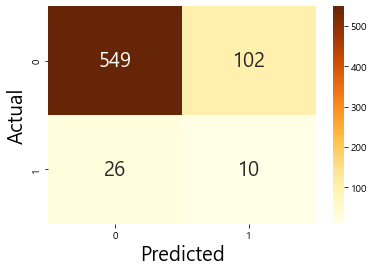

In [22]:
XGB(kospi_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.6145505455547676

예측 데이터 정확도
accuracy score : 0.566
precision score : 0.306
recall score : 0.579
f1 score : 0.400
roc score : 0.570
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.26316    0.25333 1.00000   0.40426    0.50877
0.30000   0.36842    0.28358 1.00000   0.44186    0.57895
0.40000   0.39474    0.27869 0.89474   0.42500    0.56140
0.50000   0.56579    0.30556 0.57895   0.40000    0.57018
0.60000   0.75000    0.50000 0.26316   0.34483    0.58772
0.70000   0.75000    0.00000 0.00000   0.00000    0.50000
0.80000   0.75000    0.00000 0.00000   0.00000    0.50000
0.90000   0.75000    0.00000 0.00000   0.00000    0.50000
None


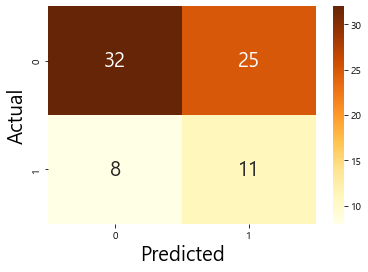

In [23]:
LG(kospi_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6236318996902318

예측 데이터 정확도
accuracy score : 0.711
precision score : 0.435
recall score : 0.526
f1 score : 0.476
roc score : 0.649
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.52632    0.32653 0.84211   0.47059    0.63158
0.30000   0.52632    0.32653 0.84211   0.47059    0.63158
0.40000   0.56579    0.34091 0.78947   0.47619    0.64035
0.50000   0.71053    0.43478 0.52632   0.47619    0.64912
0.60000   0.71053    0.43478 0.52632   0.47619    0.64912
0.70000   0.73684    0.47619 0.52632   0.50000    0.66667
0.80000   0.75000    0.50000 0.05263   0.09524    0.51754
0.90000   0.75000    0.50000 0.05263   0.09524    0.51754
None


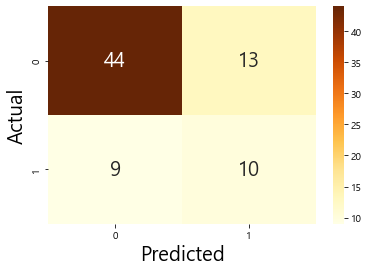

In [24]:
p_good = DT(kospi_good)

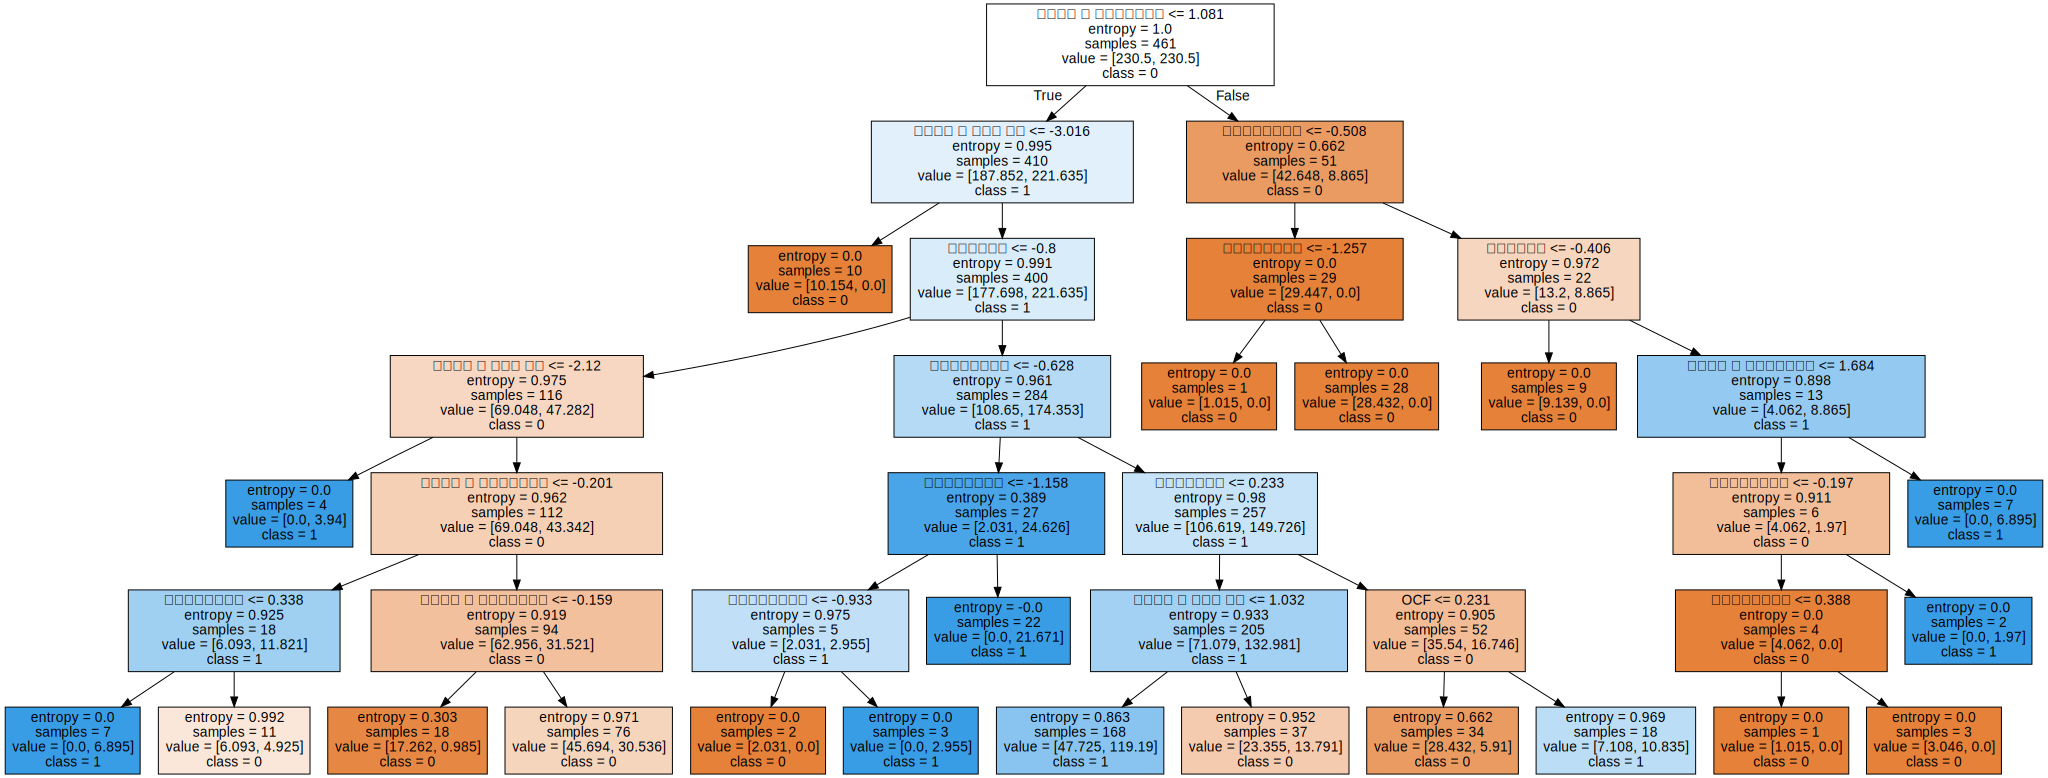

In [25]:
DT_vis(kospi_good, p_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8150364904779964

예측 데이터 정확도
accuracy score : 0.671
precision score : 0.286
recall score : 0.211
f1 score : 0.242
roc score : 0.518


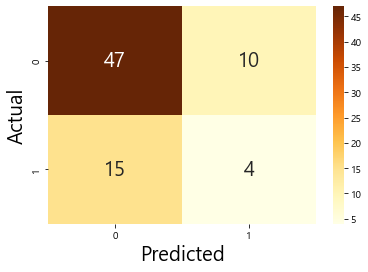

In [26]:
SVM(kospi_good, 'rbf')

In [27]:
# SVM(kospi_good, 'linear')

XGB

[00:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 3.021276595744681, 'silent': 1}
학습 데이터 정확도 :  0.7828025252842826

예측 데이터 정확도
accuracy score : 0.632
precision score : 0.371
recall score : 0.684
f1 score : 0.481
roc score : 0.649
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.50000    0.32075 0.89474   0.47222    0.63158
0.30000   0.56579    0.34091 0.78947 

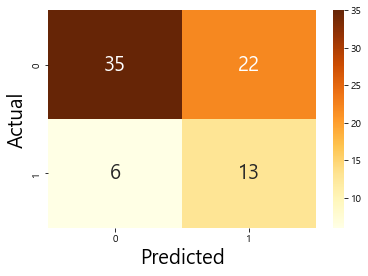

In [28]:
XGB(kospi_good)

#### 코스닥

##### ALL

Logistic Regression

최적 파라미터
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5407829864645655

예측 데이터 정확도
accuracy score : 0.537
precision score : 0.124
recall score : 0.528
f1 score : 0.201
roc score : 0.533
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11002    0.11002 1.00000   0.19823    0.50000
0.30000   0.11091    0.11012 1.00000   0.19839    0.50050
0.40000   0.16458    0.11344 0.96748   0.20307    0.51640
0.50000   0.53667    0.12381 0.52846   0.20062    0.53307
0.60000   0.85868    0.25352 0.14634   0.18557    0.54654
0.70000   0.88909    0.00000 0.00000   0.00000    0.49950
0.80000   0.88998    0.00000 0.00000   0.00000    0.50000
0.90000   0.88998    0.00000 0.00000   0.00000    0.50000
None


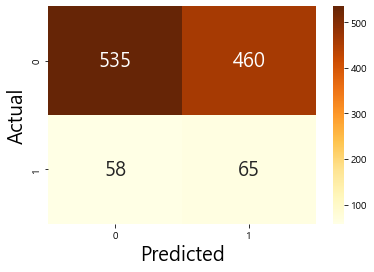

In [29]:
LG(kosdaq_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6553088659616393

예측 데이터 정확도
accuracy score : 0.576
precision score : 0.106
recall score : 0.382
f1 score : 0.165
roc score : 0.491
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.25671    0.11269 0.83740   0.19865    0.51116
0.30000   0.27460    0.10731 0.76423   0.18819    0.48915
0.40000   0.28712    0.10723 0.74797   0.18756    0.48906
0.50000   0.57603    0.10562 0.38211   0.16549    0.49106
0.60000   0.76386    0.10615 0.15447   0.12583    0.49683
0.70000   0.87657    0.05882 0.00813   0.01429    0.49602
0.80000   0.87925    0.07143 0.00813   0.01460    0.49753
0.90000   0.88014    0.07692 0.00813   0.01471    0.49803
None


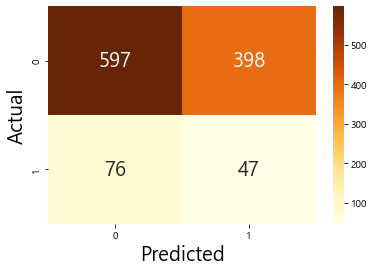

In [30]:
d_all = DT(kosdaq_all)

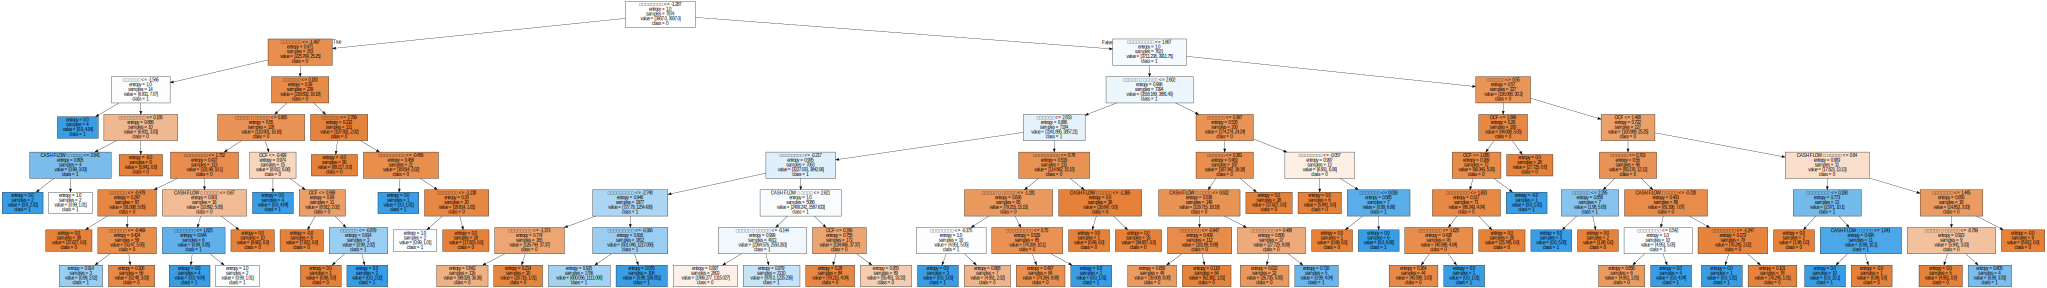

In [31]:
DT_vis(kosdaq_all, d_all)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8233521636134968

예측 데이터 정확도
accuracy score : 0.774
precision score : 0.104
recall score : 0.138
f1 score : 0.118
roc score : 0.495


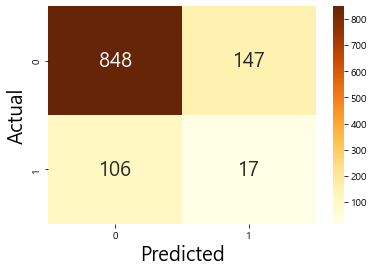

In [32]:
SVM(kosdaq_all, 'rbf')

In [33]:
# SVM(kosdaq_all, 'linear')

XGB

[01:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.056726094003242, 'silent': 1}
학습 데이터 정확도 :  0.8051172805465743

예측 데이터 정확도
accuracy score : 0.605
precision score : 0.114
recall score : 0.382
f1 score : 0.175
roc score : 0.507
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.45438    0.11532 0.59350   0.19312    0.51534
0.30000   0.50447    0.11586 0.52846  

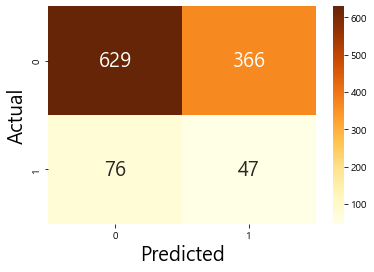

In [34]:
XGB(kosdaq_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.56803243155739

예측 데이터 정확도
accuracy score : 0.576
precision score : 0.106
recall score : 0.465
f1 score : 0.172
roc score : 0.526
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.09492    0.09492 1.00000   0.17338    0.50000
0.30000   0.09492    0.09492 1.00000   0.17338    0.50000
0.40000   0.10547    0.09515 0.98990   0.17360    0.50131
0.50000   0.57622    0.10575 0.46465   0.17228    0.52629
0.60000   0.88015    0.06667 0.02020   0.03101    0.49527
0.70000   0.90508    0.00000 0.00000   0.00000    0.50000
0.80000   0.90508    0.00000 0.00000   0.00000    0.50000
0.90000   0.90508    0.00000 0.00000   0.00000    0.50000
None


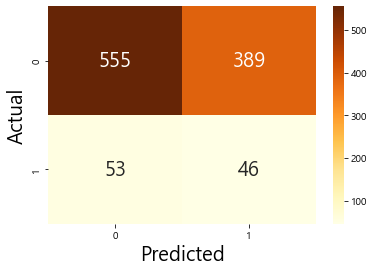

In [35]:
LG(kosdaq_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.7149798187217566

예측 데이터 정확도
accuracy score : 0.304
precision score : 0.098
recall score : 0.768
f1 score : 0.173
roc score : 0.511
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.27804    0.09729 0.79798   0.17344    0.51075
0.30000   0.30201    0.09731 0.76768   0.17273    0.51043
0.40000   0.30201    0.09731 0.76768   0.17273    0.51043
0.50000   0.30393    0.09756 0.76768   0.17312    0.51149
0.60000   0.89549    0.08333 0.01010   0.01802    0.49922
0.70000   0.89549    0.08333 0.01010   0.01802    0.49922
0.80000   0.90221    0.20000 0.01010   0.01923    0.50293
0.90000   0.90221    0.20000 0.01010   0.01923    0.50293
None


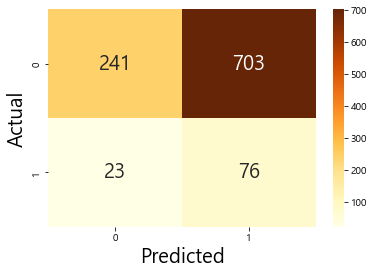

In [36]:
d_bad = DT(kosdaq_bad)

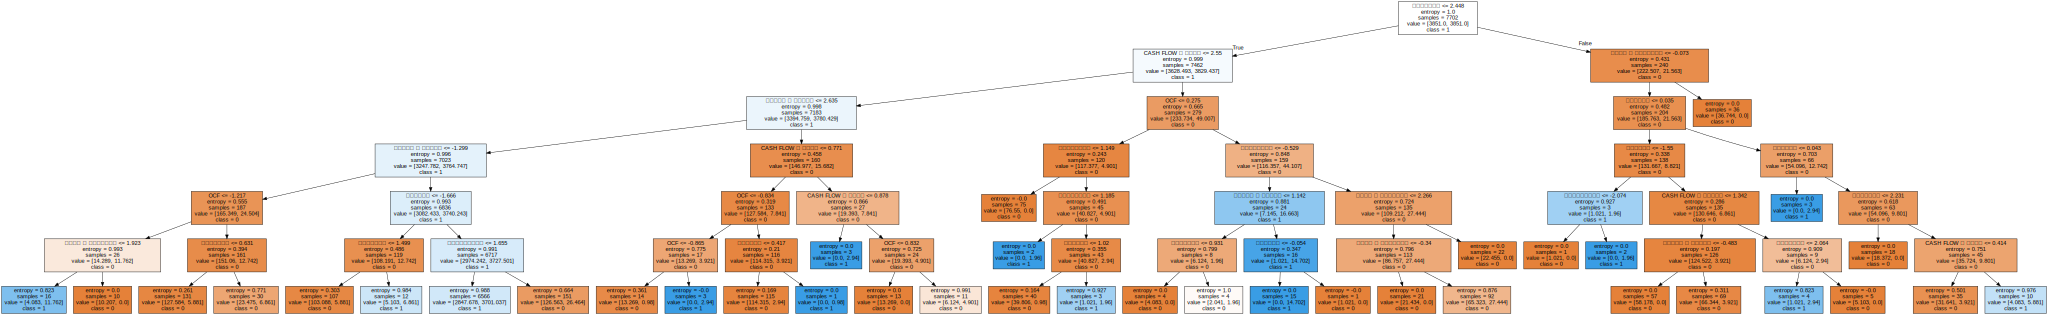

In [37]:
DT_vis(kosdaq_bad, d_bad)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8424976636773653

예측 데이터 정확도
accuracy score : 0.789
precision score : 0.094
recall score : 0.141
f1 score : 0.113
roc score : 0.499


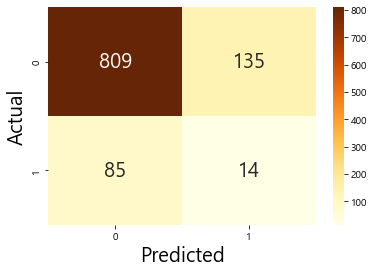

In [38]:
SVM(kosdaq_bad, 'rbf')

In [39]:
# SVM(kosdaq_bad, 'linear')

XGBoost

[04:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 9.51008064516129, 'silent': 1}
학습 데이터 정확도 :  0.8354194942115504

예측 데이터 정확도
accuracy score : 0.668
precision score : 0.105
recall score : 0.333
f1 score : 0.160
roc score : 0.518
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.53308    0.09244 0.44444   0.15304    0.49341
0.30000   0.59348    0.10269 0.42424   

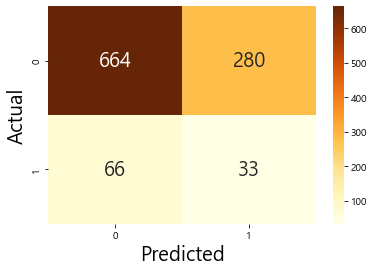

In [40]:
XGB(kosdaq_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5649909048686893

예측 데이터 정확도
accuracy score : 0.547
precision score : 0.375
recall score : 0.625
f1 score : 0.469
roc score : 0.567
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.32000    0.32000 1.00000   0.48485    0.50000
0.30000   0.32000    0.32000 1.00000   0.48485    0.50000
0.40000   0.32000    0.32000 1.00000   0.48485    0.50000
0.50000   0.54667    0.37500 0.62500   0.46875    0.56740
0.60000   0.68000    0.00000 0.00000   0.00000    0.50000
0.70000   0.68000    0.00000 0.00000   0.00000    0.50000
0.80000   0.68000    0.00000 0.00000   0.00000    0.50000
0.90000   0.68000    0.00000 0.00000   0.00000    0.50000
None


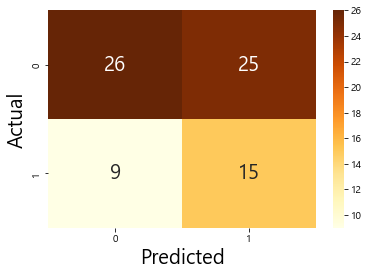

In [41]:
LG(kosdaq_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6719651603078569

예측 데이터 정확도
accuracy score : 0.560
precision score : 0.390
recall score : 0.667
f1 score : 0.492
roc score : 0.588
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.46667    0.35185 0.79167   0.48718    0.55270
0.30000   0.48000    0.35849 0.79167   0.49351    0.56250
0.40000   0.56000    0.39024 0.66667   0.49231    0.58824
0.50000   0.56000    0.39024 0.66667   0.49231    0.58824
0.60000   0.56000    0.39024 0.66667   0.49231    0.58824
0.70000   0.61333    0.30769 0.16667   0.21622    0.49510
0.80000   0.62667    0.30000 0.12500   0.17647    0.49387
0.90000   0.62667    0.30000 0.12500   0.17647    0.49387
None


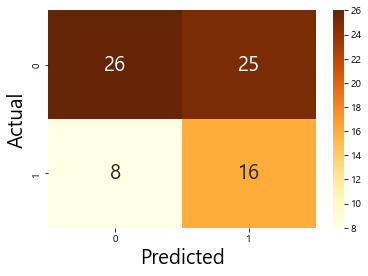

In [42]:
d_good = DT(kosdaq_good)

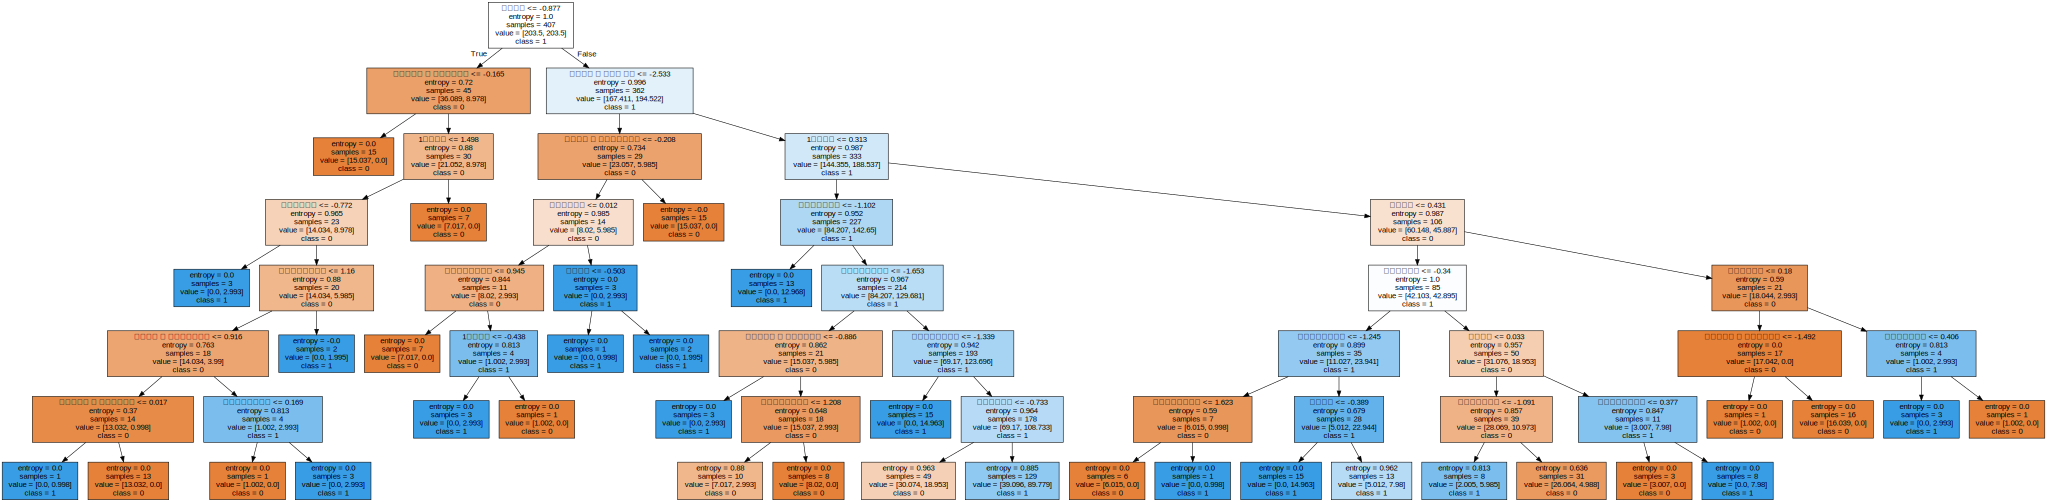

In [43]:
DT_vis(kosdaq_good, d_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.7985457485457486

예측 데이터 정확도
accuracy score : 0.693
precision score : 0.545
recall score : 0.250
f1 score : 0.343
roc score : 0.576


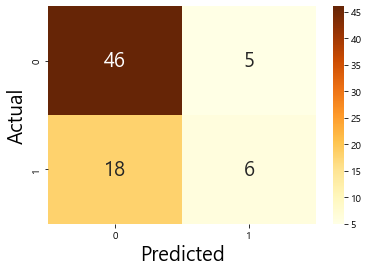

In [44]:
SVM(kosdaq_good, 'rbf')

In [45]:
# SVM(kosdaq_good, 'linear')

XGB

[04:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 2.0991735537190084, 'silent': 1}
학습 데이터 정확도 :  0.7317383512544803

예측 데이터 정확도
accuracy score : 0.640
precision score : 0.455
recall score : 0.625
f1 score : 0.526
roc score : 0.636
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.49333    0.37500 0.87500   0.52500    0.59436
0.30000   0.50667    0.36735 0.75000

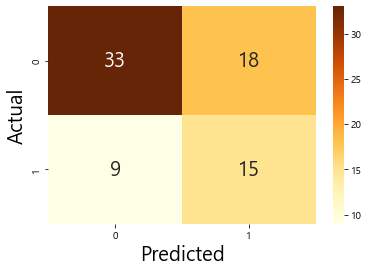

In [46]:
XGB(kosdaq_good)